In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential

In [2]:
train_dir='/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height = 224
img_width = 224
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  
)

# Create the training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training' 
)

# Create the validation data generator
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 56251 images belonging to 38 classes.
Found 14044 images belonging to 38 classes.


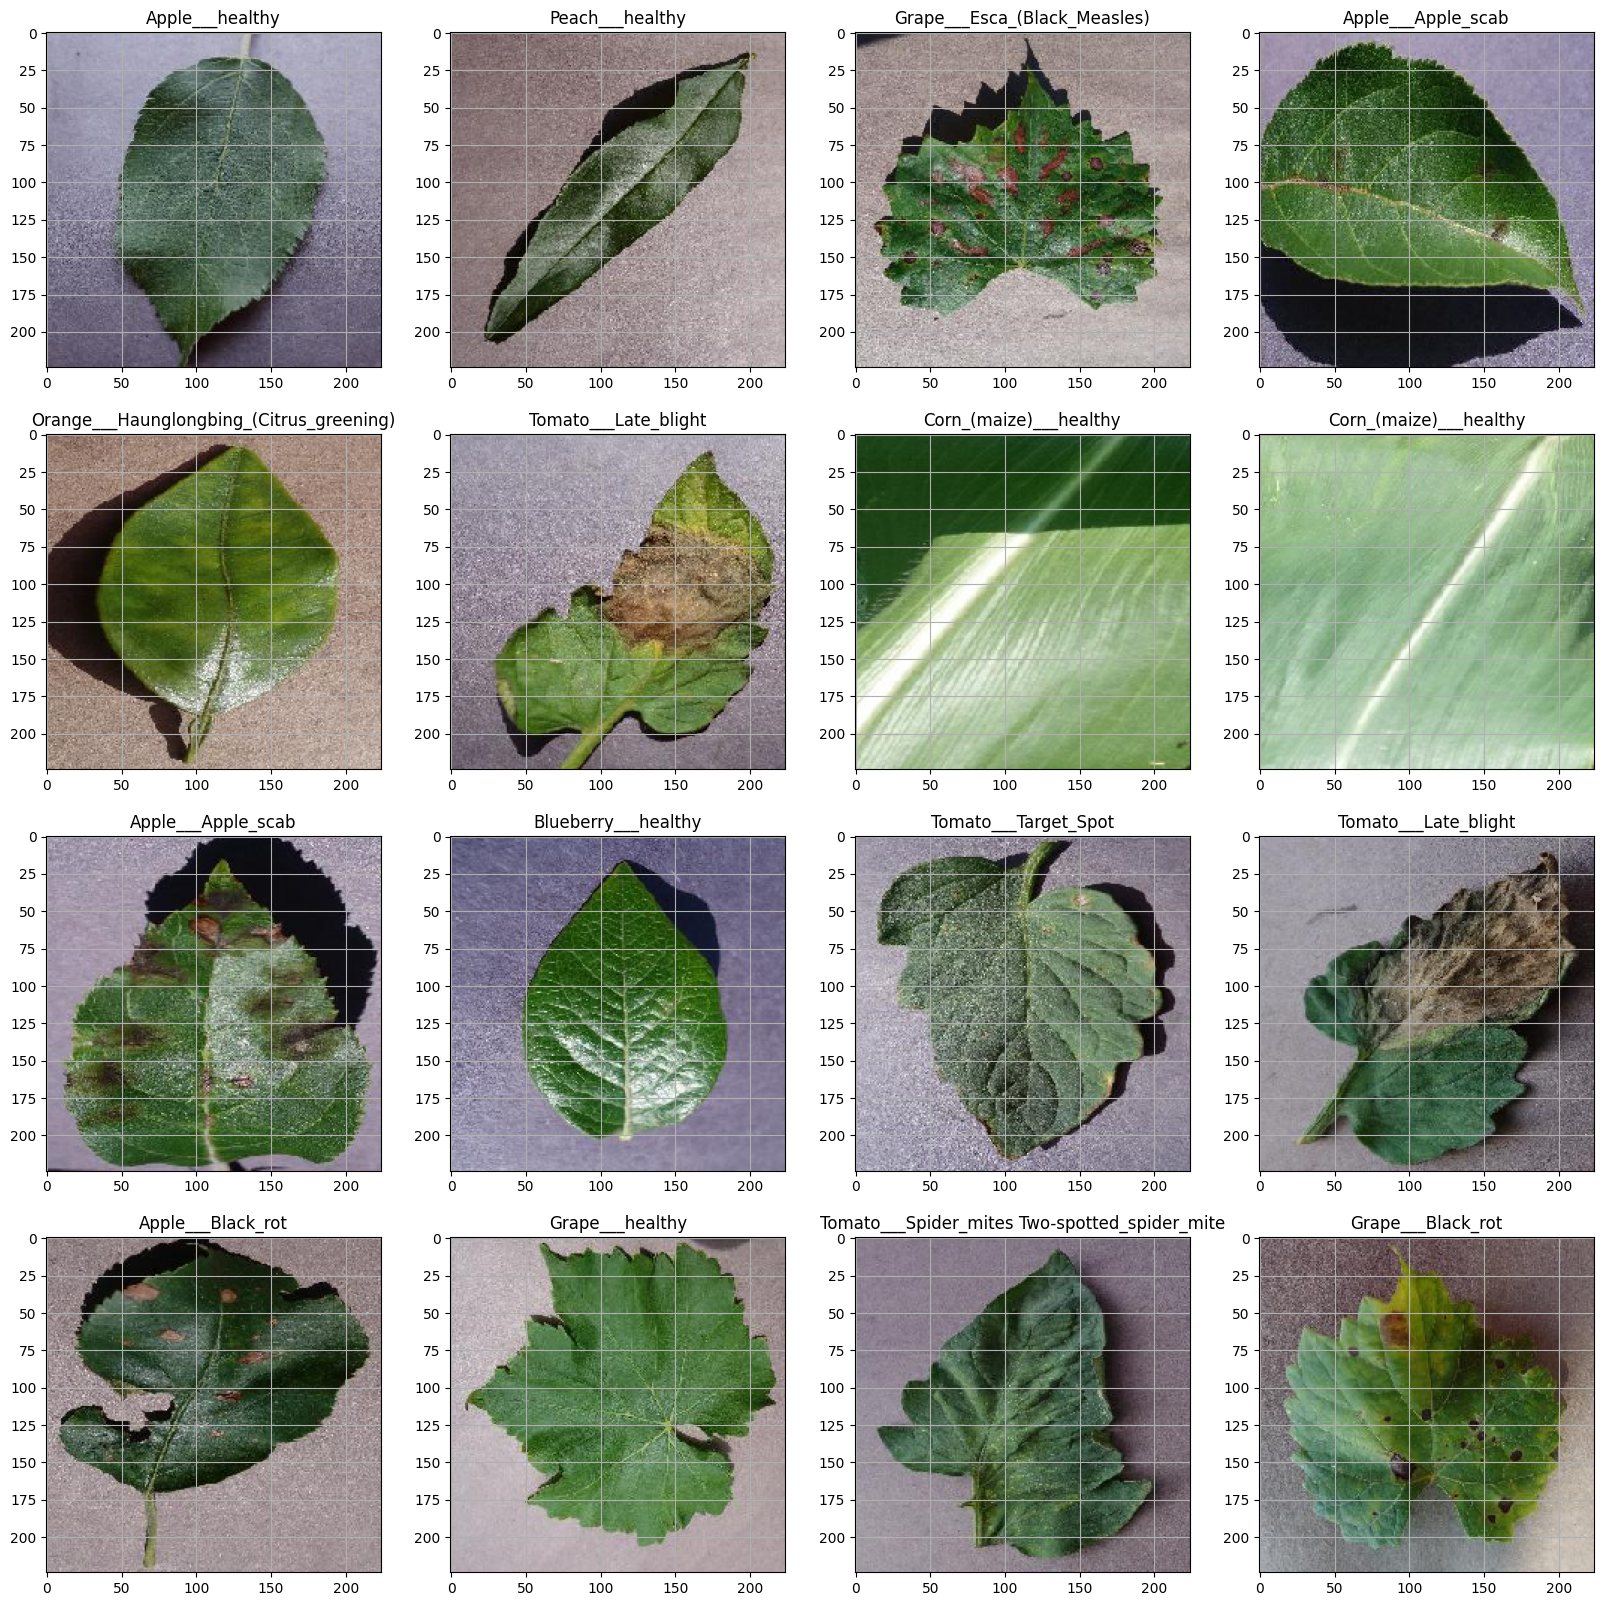

In [4]:
classes=list(train_generator.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch  , y_batch in train_generator:
    # create a grid of 3x3 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])   # when y is categorical
        # plt.title(classes[int(y_batch[i])])   # when y is binary or sparse 
        plt.grid(None)
    # show the plot
    plt.show()
    break

In [5]:
test_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

In [6]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 17572 images belonging to 38 classes.


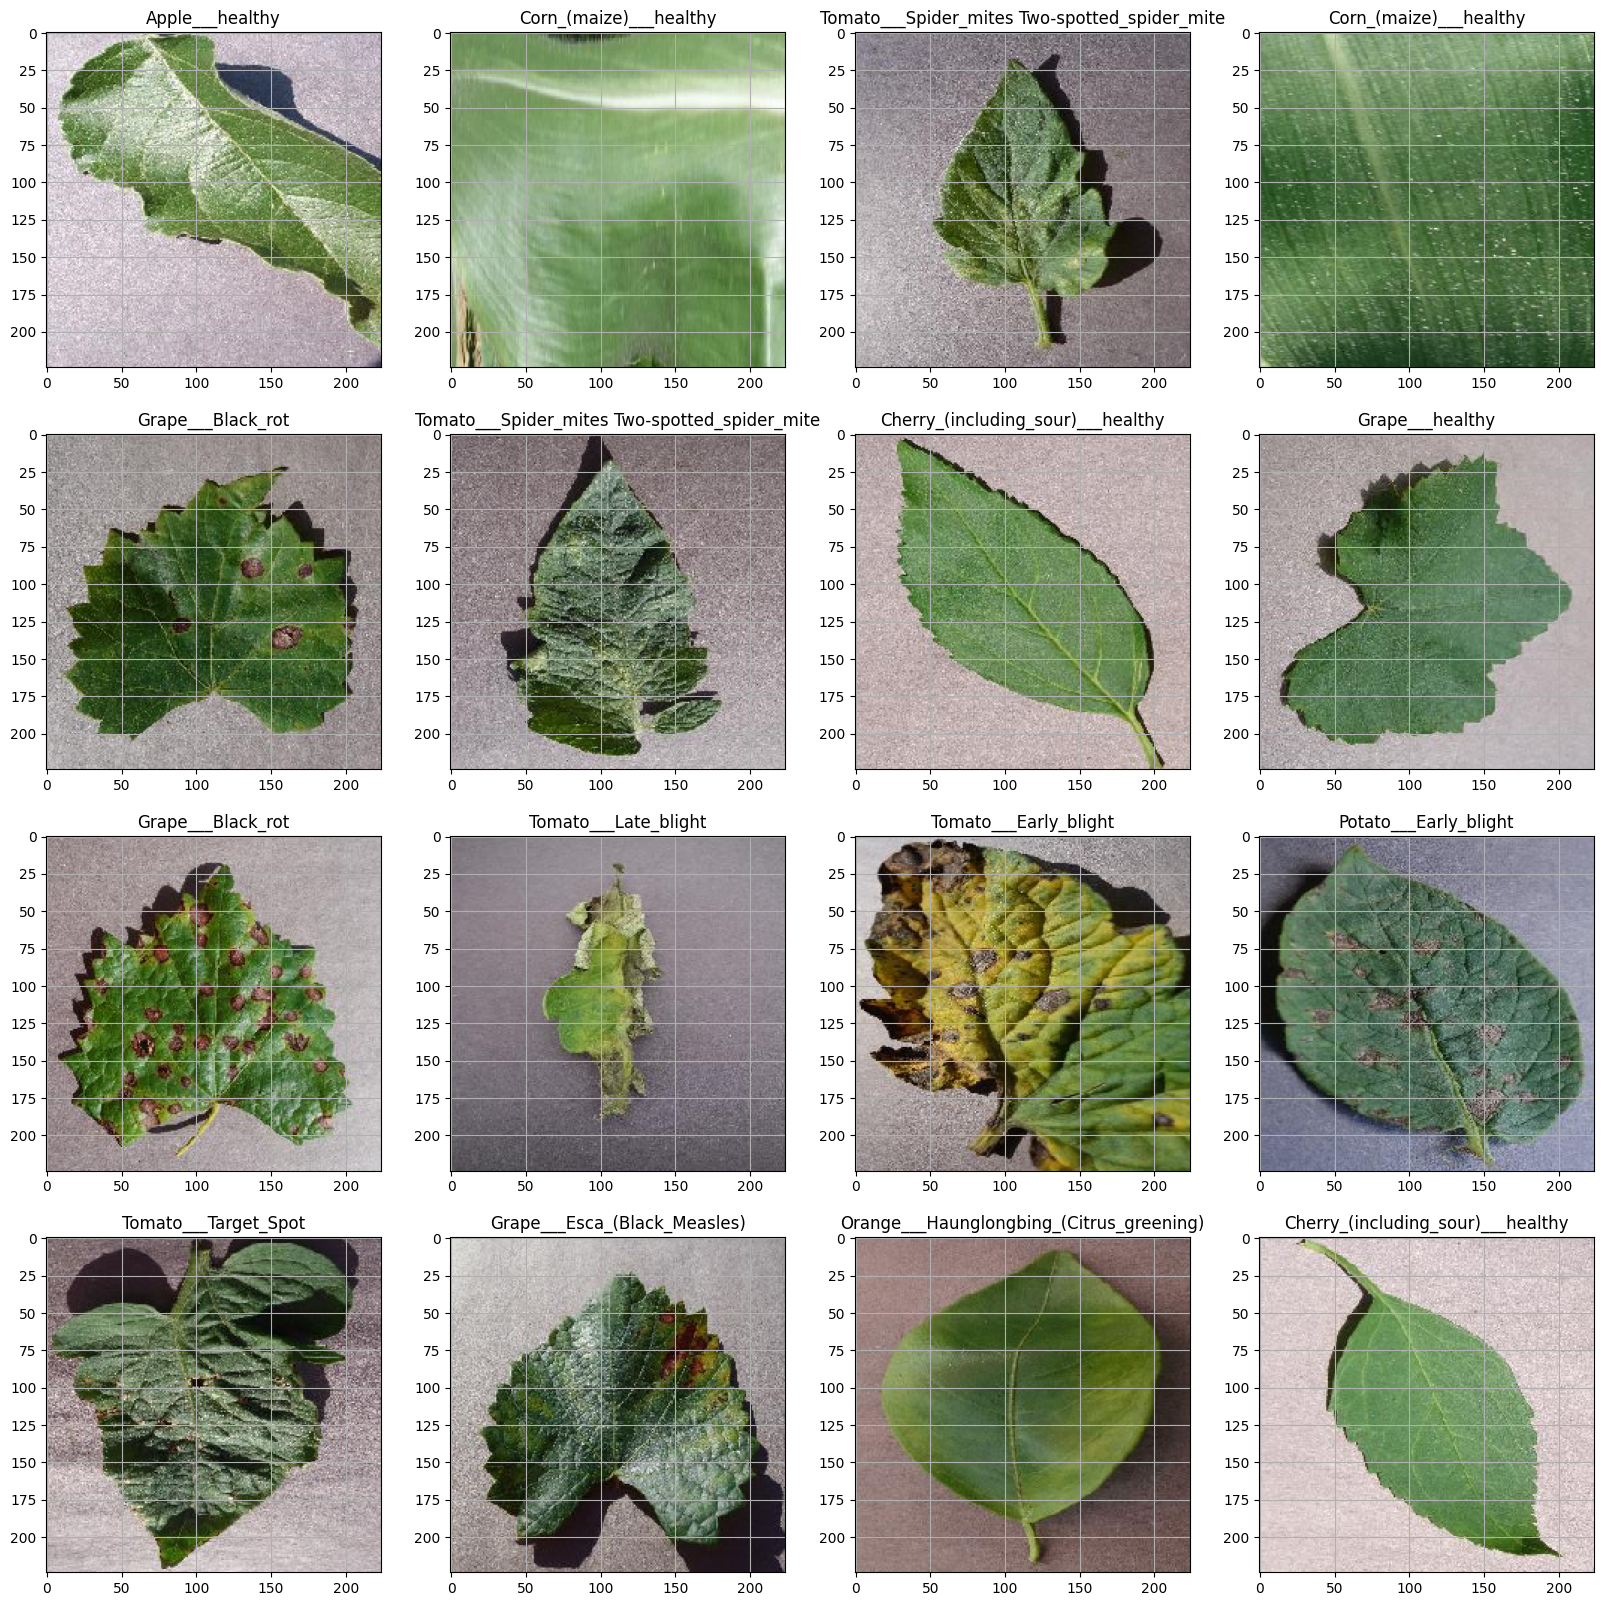

In [7]:
classes=list(val_generator.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in val_generator:
    # create a grid of 3x3 imag
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])   # when y is categorical
        # plt.title(classes[int(y_batch[i])])   # when y is binary or sparse 
        plt.grid(None)
    # show the plot
    plt.show()
    break

In [8]:
metrics = [
    'accuracy',
    Precision(),
    Recall(),
]

In [9]:
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3
from tensorflow.keras import layers, models
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Define hyperparameters

CNN_model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(265, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(38, activation='softmax')  
])

epochs = 50

# Transfer Learning with VGG16
base_model_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model_vgg19.trainable = False

# Define the model architecture
model_vgg19 = models.Sequential([
    base_model_vgg19,
     GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(38, activation='softmax')
])


# Transfer Learning with ResNet50
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model_resnet50.trainable = False

model_resnet50 = models.Sequential([
    base_model_resnet50,
     GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(38, activation='softmax')
])

# Transfer Learning with InceptionV3
base_model_inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model_inceptionv3.trainable = False

model_inceptionv3 = models.Sequential([
    base_model_inceptionv3,
     GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(38, activation='softmax')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [10]:
# Compile the models
CNN_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics= metrics)
model_vgg19.compile(optimizer='adam', loss='categorical_crossentropy', metrics= metrics)
model_resnet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics= metrics)
model_inceptionv3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

model_ReduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_lr=0.000001)

callbacks=[early_stopping,model_checkpoint,model_ReduceLROnPlateau]

In [12]:
def evaluate_model(model, train_gen, valid_gen, test_gen):
    # Evaluate the model on the training data generator
    model_eval_train = model.evaluate(train_gen)
    print('Training Data:')
    print('Loss:      ', model_eval_train[0])
    print('Accuracy:  ', model_eval_train[1])
    print('Precision: ', model_eval_train[2])
    print('Recall:    ', model_eval_train[3])
    
    # Evaluate the model on the validation data generator
    model_eval_valid = model.evaluate(valid_gen)
    print('\nValidation Data:')
    print('Loss:      ', model_eval_valid[0])
    print('Accuracy:  ', model_eval_valid[1])
    print('Precision: ', model_eval_valid[2])
    print('Recall:    ', model_eval_valid[3])
    
    # Evaluate the model on the test data generator
    model_eval_test = model.evaluate(test_gen)
    print('\nTest Data:')
    print('Loss:      ', model_eval_test[0])
    print('Accuracy:  ', model_eval_test[1])
    print('Precision: ', model_eval_test[2])
    print('Recall:    ', model_eval_test[3])
    
    return (np.round(model_eval_train[0], 2), np.round(model_eval_valid[0], 2), np.round(model_eval_test[0], 2),
            np.round(model_eval_train[1], 2), np.round(model_eval_valid[1], 2), np.round(model_eval_test[1], 2),
            np.round(model_eval_train[2], 2), np.round(model_eval_valid[2], 2), np.round(model_eval_test[2], 2),
            np.round(model_eval_train[3], 2), np.round(model_eval_valid[3], 2), np.round(model_eval_test[3], 2),)

In [13]:
history_cnn = CNN_model.fit(train_generator, epochs=epochs, validation_data=val_generator ,  callbacks = callbacks)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729888506.286737      86 service.cc:145] XLA service 0x79035800b9d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729888506.286816      86 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/879 ━━━━━━━━━━━━━━━━━━━━ 52s 59ms/step - accuracy: 0.0234 - loss: 3.7495 - precision: 0.0000e+00 - recall: 0.0000e+00   

I0000 00:00:1729888515.466649      86 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


879/879 ━━━━━━━━━━━━━━━━━━━━ 460s 508ms/step - accuracy: 0.3398 - loss: 2.3743 - precision: 0.6921 - recall: 0.2005 - val_accuracy: 0.8238 - val_loss: 0.5633 - val_precision: 0.8898 - val_recall: 0.7544 - learning_rate: 0.0010
Epoch 2/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 210s 238ms/step - accuracy: 0.7903 - loss: 0.6771 - precision: 0.8654 - recall: 0.7241 - val_accuracy: 0.8917 - val_loss: 0.3454 - val_precision: 0.9287 - val_recall: 0.8571 - learning_rate: 0.0010
Epoch 3/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 211s 238ms/step - accuracy: 0.8720 - loss: 0.4030 - precision: 0.9089 - recall: 0.8407 - val_accuracy: 0.9069 - val_loss: 0.2885 - val_precision: 0.9304 - val_recall: 0.8856 - learning_rate: 0.0010
Epoch 4/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 209s 236ms/step - accuracy: 0.8988 - loss: 0.3094 - precision: 0.9248 - recall: 0.8786 - val_accuracy: 0.9241 - val_loss: 0.2323 - val_precision: 0.9371 - val_recall: 0.9132 - learning_rate: 0.0010
Epoch 5/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 209s 236ms/step - a

In [14]:
# Train the models
history_vgg19 = model_vgg19.fit(train_generator, epochs=epochs, validation_data=val_generator ,  callbacks = callbacks)

Epoch 1/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 251s 264ms/step - accuracy: 0.3236 - loss: 2.5354 - precision: 0.9398 - recall: 0.4391 - val_accuracy: 0.7632 - val_loss: 0.9118 - val_precision: 0.9310 - val_recall: 0.5143 - learning_rate: 0.0010
Epoch 2/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 212s 240ms/step - accuracy: 0.6905 - loss: 1.0182 - precision: 0.8650 - recall: 0.4964 - val_accuracy: 0.8222 - val_loss: 0.6237 - val_precision: 0.9221 - val_recall: 0.7024 - learning_rate: 0.0010
Epoch 3/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 214s 242ms/step - accuracy: 0.7554 - loss: 0.7917 - precision: 0.8728 - recall: 0.6282 - val_accuracy: 0.8372 - val_loss: 0.5413 - val_precision: 0.9195 - val_recall: 0.7484 - learning_rate: 0.0010
Epoch 4/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 213s 240ms/step - accuracy: 0.7887 - loss: 0.6792 - precision: 0.8802 - recall: 0.6899 - val_accuracy: 0.8583 - val_loss: 0.4599 - val_precision: 0.9235 - val_recall: 0.7941 - learning_rate: 0.0010
Epoch 5/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 214s 242

In [15]:
history_resnet50 = model_resnet50.fit(train_generator, epochs=epochs, validation_data=val_generator,  callbacks = callbacks)

Epoch 1/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 236s 251ms/step - accuracy: 0.0365 - loss: 3.6083 - precision: 0.9278 - recall: 0.3428 - val_accuracy: 0.0755 - val_loss: 3.3636 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 209s 236ms/step - accuracy: 0.0610 - loss: 3.4042 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0893 - val_loss: 3.2815 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 211s 239ms/step - accuracy: 0.0754 - loss: 3.3376 - precision: 0.4949 - recall: 4.8145e-05 - val_accuracy: 0.1312 - val_loss: 3.1858 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 215s 244ms/step - accuracy: 0.0846 - loss: 3.2800 - precision: 0.5452 - recall: 6.9046e-05 - val_accuracy: 0.1548 - val_loss: 3.1264 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010


In [16]:
history_inceptionv3 = model_inceptionv3.fit(train_generator, epochs=epochs, validation_data=val_generator ,  callbacks = callbacks)

Epoch 1/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 251s 264ms/step - accuracy: 0.5340 - loss: 1.6526 - precision: 0.8118 - recall: 0.2473 - val_accuracy: 0.8550 - val_loss: 0.4721 - val_precision: 0.9230 - val_recall: 0.7813 - learning_rate: 0.0010
Epoch 2/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 213s 241ms/step - accuracy: 0.7921 - loss: 0.6542 - precision: 0.8734 - recall: 0.7205 - val_accuracy: 0.8669 - val_loss: 0.3992 - val_precision: 0.9169 - val_recall: 0.8204 - learning_rate: 0.0010
Epoch 3/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 213s 241ms/step - accuracy: 0.8194 - loss: 0.5527 - precision: 0.8835 - recall: 0.7638 - val_accuracy: 0.8831 - val_loss: 0.3533 - val_precision: 0.9217 - val_recall: 0.8481 - learning_rate: 0.0010
Epoch 4/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 214s 242ms/step - accuracy: 0.8400 - loss: 0.4906 - precision: 0.8918 - recall: 0.7941 - val_accuracy: 0.8924 - val_loss: 0.3257 - val_precision: 0.9222 - val_recall: 0.8658 - learning_rate: 0.0010
Epoch 5/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 213s 241

In [17]:
Final_report = []

In [18]:
Final_report.append(evaluate_model(CNN_model, train_generator, val_generator, test_generator))
Final_report.append(evaluate_model(model_vgg19, train_generator, val_generator, test_generator))
Final_report.append(evaluate_model(model_resnet50, train_generator, val_generator, test_generator))
Final_report.append(evaluate_model(model_inceptionv3, train_generator, val_generator, test_generator))


879/879 ━━━━━━━━━━━━━━━━━━━━ 169s 192ms/step - accuracy: 0.9990 - loss: 0.0043 - precision: 0.9991 - recall: 0.9989
Training Data:
Loss:       0.004346111323684454
Accuracy:   0.9988800287246704
Precision:  0.9990042448043823
Recall:     0.9987733364105225
220/220 ━━━━━━━━━━━━━━━━━━━━ 42s 191ms/step - accuracy: 0.9561 - loss: 0.1708 - precision: 0.9603 - recall: 0.9537

Validation Data:
Loss:       0.16343991458415985
Accuracy:   0.9570634961128235
Precision:  0.9605103135108948
Recall:     0.954286515712738
275/275 ━━━━━━━━━━━━━━━━━━━━ 181s 658ms/step - accuracy: 0.9603 - loss: 0.1480 - precision: 0.9635 - recall: 0.9583

Test Data:
Loss:       0.14509797096252441
Accuracy:   0.9618711471557617
Precision:  0.9648270010948181
Recall:     0.960050106048584
879/879 ━━━━━━━━━━━━━━━━━━━━ 172s 196ms/step - accuracy: 0.7741 - loss: 0.8831 - precision: 0.9397 - recall: 0.5261
Training Data:
Loss:       0.8804110884666443
Accuracy:   0.7743862271308899
Precision:  0.9390714764595032
Recall:   

In [19]:
Model_Names = ['CNN_model','VGG19', 'ResNet50', 'InceptionV3']

In [20]:
Model_Accuracy = pd.DataFrame(
    Final_report,
    index=Model_Names,
    columns=[
        'Train Loss', 'Validation Loss', 'Test Loss',
        'Train Accuracy', 'Validation ACC', 'Test ACC',
        'Train Precision', 'Validation Precision', 'Test Precision',
        'Train Recall', 'Validation Recall', 'Test Recall',
    ]
)

In [21]:
Model_Accuracy

Train Loss  Validation Loss  Test Loss  Train Accuracy  \
CNN_model          0.00             0.16       0.15            1.00   
VGG19              0.88             0.91       0.89            0.77   
ResNet50           3.36             3.36       3.36            0.08   
InceptionV3        0.41             0.47       0.46            0.88   

             Validation ACC  Test ACC  Train Precision  Validation Precision  \
CNN_model              0.96      0.96             1.00                  0.96   
VGG19                  0.76      0.77             0.94                  0.93   
ResNet50               0.08      0.08             0.00                  0.00   
InceptionV3            0.86      0.86             0.94                  0.92   

             Test Precision  Train Recall  Validation Recall  Test Recall  
CNN_model              0.96          1.00               0.95         0.96  
VGG19                  0.94          0.53               0.51         0.52  
ResNet50               0.00          0.00               0.00         0.00  
InceptionV3            0.93          0.81               0.78         0.79

In [22]:
Model_Accuracy.to_csv('Report.csv', index = True)